# Multi-Scenario MORDM Gelderland
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate possible strategies for the Gelderland province to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies for the Gelderland province, namely minimizing casualties and damages across the model runtime in dike rings 1-3 and minimizing dike investment costs for all dike rings. 

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform as well as other parameters used in this notebook

In [4]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/10000Scenarios_NoAction_PF1.tar.gz"

#Province name
province = "Gelderland"

## Model Specification
Problem Formulation 6, specified in the problem_formulation.py file is calles to initiate the dike model from Gelderlands framing. 

In [18]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(6)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [4]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/10000Scenarios_NoAction_PF1.tar.gz


In [5]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario
Due to limited computational resources, we ran 20000 function evaluations in the epsilon-NSGA II multi-objective evolutionary algorithm (MOEA) implemented in the ema_workbench. As a convergence metric, the epsilon progress was used. 

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 499/20000 nfe
[MainProcess/INFO] generation 10: 996/20000 nfe
[MainProcess/INFO] generation 15: 1496/20000 nfe
[MainProcess/INFO] generation 20: 1994/20000 nfe
[MainProcess/INFO] generation 25: 2492/20000 nfe
[MainProcess/INFO] generation 30: 2988/20000 nfe
[MainProcess/INFO] generation 35: 3486/20000 nfe
[MainProcess/INFO] generation 40: 3986/20000 nfe
[MainProcess/INFO] generation 45: 4486/20000 nfe
[MainProcess/INFO] generation 50: 4985/20000 nfe
[MainProcess/INFO] generation 55: 5483/20000 nfe
[MainProcess/INFO] generation 60: 5978/20000 nfe
[MainProcess/INFO] generation 65: 6478/20000 nfe
[MainProcess/INFO] generation 70: 6976/20000 nfe
[MainProcess/INFO] generation 75: 7472/20000 nfe
[MainProcess/INFO] generation 80: 7971/20000 nfe
[MainProcess/INFO] generation 85: 8470/20000 nfe
[MainProcess/INFO] generation 90: 8970/20000 nfe
[MainProcess/INFO] generation 95: 9468/20000

In [7]:
results, convergence = results_epsilon_0_1

In [8]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_"+province+".tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/20000nfe_BaseCaseMORDM_Gelderland.tar.gz


In [104]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_"+province+".tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/20000nfe_BaseCaseMORDM_Gelderland.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

In [105]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
fig0 = px.line(convergence, x = "nfe", y = "epsilon_progress", title="Epsilon Progress")
fig0.show()

As it can be seen in the plot, the algorithm did not fully converge. However, due to limited computational resources we decided to go forward with the solutions found after 20.000 function evaluations. For a more precice analysis, we encourage other researchers to use high-performance computational clusters to run the MOEA until full convergence is reached.

## Show tradeoffs in the resulting optimal policies
The algorithm found 973 solutions, which are displayed in the following section of the notebook.   

In [110]:
# fig1 = px.parallel_coordinates(results.iloc[:, 31::], labels= 
#    {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", 
#    "A3 Expected Annual Damage" : "A3 Damage", 
#    "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", 
#    "A3 Aggr Expected Number of Deaths" : "A3 Casualties", 
#    "A1_5 Dike Investment Costs" : "Investment Costs", 
#    "Room for River Investment Costs" : "RfR Investment Costs"}, 
#    color=results.index, 
#    dimensions = ["A1_2 Aggr Expected Annual Damage", 
#                    "A3 Expected Annual Damage", 
#                    "A1_2 Aggr Expected Number of Deaths",
#                    "A3 Aggr Expected Number of Deaths", 
#                    "A1_5 Dike Investment Costs", 
#                    "Room for River Investment Costs" ])
# fig1.update_layout(showlegend=False)
# fig1.show()

![Tradeoffs](../figures/Gelderland_Tradeoffs_1ReferenceScenario.png)


To show the tradeoffs more clearly, we aggregate the costs and the expected number of casualties, as well as the investment costs with the evacuation costs

In [97]:
results_agg = results.iloc[:, 31::]
results_agg["Expected Casualties"] = results_agg["A1_2 Aggr Expected Number of Deaths"] + results_agg["A3 Aggr Expected Number of Deaths"]
results_agg["Expected Damage"] = results_agg["A1_2 Aggr Expected Annual Damage"] + results_agg["A3 Expected Annual Damage"]
results_agg["Traditional Costs"] = results_agg["A1_5 Dike Investment Costs"] + results_agg["Evacuation Costs"]


In [116]:
#fig2 = px.parallel_coordinates(results_agg, dimensions=["Expected Casualties","Expected Damage", "Traditional Costs", "Room for River Investment Costs"], color = results_agg.index)
#fig2.update_layout(showlegend=False)
#fig2.show()

![](../figures/Gelderland_Tradeoffs_Aggr_1ReferenceScenario.png)

## Re-Evaluate under deep uncertainty
For evaluating the promising policies under deep uncertainty, we set a hard limit on one expected casualties below 0.001 and expected damages below €100.000. 

In [14]:
results_subset = results[
    ((results["A1_2 Aggr Expected Number of Deaths"] + results["A3 Aggr Expected Number of Deaths"]) < 0.001) &
    ((results["A1_2 Aggr Expected Annual Damage"] + results["A3 Expected Annual Damage"]) < 100000) ]

We further use the remaining policies to test them under deep uncertainty by running the policies for 1000 scenarios each. 

In [15]:
policies = results_subset.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [16]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 18 policies * 1 model(s) = 18000 experiments
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16200 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
#Save results
save_results(results, "../results/DeepUncertainty8policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty8policies_1000scenarios_Gelderland.tar.gz


In [99]:
#Load results
results = load_results("../results/DeepUncertainty8policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")
experiments, outcomes = results


[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty8policies_1000scenarios_Gelderland.tar.gz


## Robustness Evaluation
### Signal-to-noise Ratio
To find the most robust policy, we rate the different policies by calculating the signal-to-noise ratio. For those model outcomes which are to be minimized, this metric multiplies the mean over all scenarios times the standard deviation. In that sense, the higher the signal-to-noise ratio is for a given policy over the outcomes, the less robust the policy performs. 

In [100]:
#Define a function to calculate the signal-to-noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [101]:
#Calculate the signal-to-noise ratio 
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores = scores.reset_index()
scores

,index,A1_2 Aggr Expected Annual Damage,A3 Expected Annual Damage,A1_2 Aggr Expected Number of Deaths,A3 Aggr Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,26,1.950930e+11,2.472914e+10,2.290124e-09,1.522982e-09,0.000000,0.0,1.269112e+05
1,120,5.736757e+13,1.247349e+11,3.369952e-07,7.914261e-09,0.000000,0.0,7.006888e+05
2,416,2.241515e+14,2.876282e+09,8.737306e-05,7.049526e-09,0.000000,0.0,0.000000e+00
3,417,1.849846e+15,2.731501e+10,1.886190e-05,1.785753e-09,3054.828216,0.0,2.600725e+05
4,419,5.573449e+13,5.152380e+09,1.998038e-07,2.559858e-10,0.000000,0.0,1.373088e+05
5,422,5.100384e+13,3.421490e+10,1.191449e-05,9.247041e-08,1013.169417,0.0,0.000000e+00
6,423,5.619190e+13,2.653684e+10,1.397581e-05,7.522977e-08,3806.437913,0.0,0.000000e+00
7,467,2.527578e+12,2.477728e+11,6.920938e-07,6.676501e-07,1100.948388,0.0,0.000000e+00
8,471,1.167043e+14,5.152380e+09,3.963251e-05,1.777679e-08,1730.115180,0.0,0.000000e+00
9,491,3.248518e+11,2.159940e+10,4.782207e-09,9.709301e-10,0.000000,0.0,8.427690e+04


For a better visual understanding, we will plot the stn ratio in a parallel coordinates plot. 

In [118]:
#fig3 = px.parallel_coordinates(scores, labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"}, color = scores.index, dimensions=["A1_2 Aggr Expected Annual Damage", "A3 Expected Annual Damage", "A1_2 Aggr Expected Number of Deaths","A3 Aggr Expected Number of Deaths", "A1_5 Dike Investment Costs", "Room for River Investment Costs" ])
#fig3.show()

We find some robust policies, as seen in the graph.

![](../figures/Gelderland_stnr.png)



### Maximum Regret
Another robustness criterion is the maximum regret measure. We again calculate this measure for every policy selected

In [119]:
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

In [120]:
max_regret = pd.DataFrame(max_regret)
max_regret = max_regret.reindex()

In [121]:
fig = px.imshow(max_regret/max_regret.max(), labels=dict(x="Outcomes", y = "Policies", color = "Maximum regret"))
fig.show()

Although not numbered, it can clearly be seen that policy 7, for example, shows little regret for outcomes 2, 4 and 6. Therefore this policy might be a robust solution when only considering the initial reference case scenario based on the worst deaths. However, we continue looking for more robust solutions across multiple reference scenarios using the PRIM algorithm. 

## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. For Gelderland, we focus on such scenarios where deaths and damages occur, and where the total costs are above 4 Billion €. 

In [122]:

condition= {}


condition["condition1"] = outcomes["A1_2 Aggr Expected Annual Damage"] + outcomes["A3 Expected Annual Damage"] + outcomes["A1_2 Aggr Expected Number of Deaths"] + outcomes["A3 Aggr Expected Number of Deaths"]

condition["condition2"] = outcomes["A1_5 Dike Investment Costs"] + outcomes["Evacuation Costs"] + outcomes["Room for River Investment Costs"]

condition1 = condition["condition1"] > 0 

condition2 = condition["condition2"] > 4e9

In [123]:
x = experiments.iloc[:,0:19]
y = (condition1 | condition2)
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 18000 points remaining, containing 8570 cases of interest
[MainProcess/INFO] mean: 0.5673076923076923, mass: 0.052, coverage: 0.06196032672112019, density: 0.5673076923076923 restricted_dimensions: 10


In [124]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 10, as it shows a good mixture between coverage and density. 

In [125]:
n_box = 10
box.inspect(n_box)


coverage    0.490198
density     0.489285
id                10
mass           0.477
mean        0.489285
res_dim            7
Name: 10, dtype: object

                          box 10                   \
                             min              max   
A.1_pfail            8.68381e-05         0.899376   
A.2_pfail            0.000278511         0.936279   
A.5_pfail            0.000378219         0.942312   
discount rate 2  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}   
A.4_pfail                0.09978         0.999303   
A.3_Bmax                  45.537          333.938   
A.1_Bmax                 42.5543          349.721   

                                                            
                                                 qp values  
A.1_pfail                       [-1.0, 0.2225219531244701]  
A.2_pfail                       [-1.0, 0.4055052801398871]  
A.5_pfail                      [-1.0, 0.43291997172602514]  
discount rate 2                [0.23812764552794194, -1.0]  
A.4_p

In [126]:
box.select(n_box)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}

In [127]:
#Save results
save_results([scens_in_box.reindex(), outcomes_in_box], '../results/mordm_'+str(n_box)+'_'+province+'.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/mordm_10_Gelderland.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 

In [128]:
#Load results
# mordm_results = load_results('../results/mordm_29_Gelderland.tar.gz')
results_df = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), pd.DataFrame(outcomes_in_box)], axis = 1)

In [129]:
#Sum up Deaths and Damages
results_df["Deaths Aggregated"] = results_df["A1_2 Aggr Expected Number of Deaths"] + results_df["A3 Aggr Expected Number of Deaths"]
results_df["Damages Aggregated"] = results_df["A1_2 Aggr Expected Annual Damage"] + results_df["A3 Expected Annual Damage"]

In [130]:
#Get the three reference scenarios
scenario_indices = [results_df.sort_values(["Evacuation Costs"]).tail(1).index[0], 
                    results_df.sort_values(["Deaths Aggregated"]).tail(1).index[0], 
                    results_df.sort_values(["Damages Aggregated"]).tail(1).index[0]]
selected = results_df.iloc[scenario_indices, 0:19]


In [131]:
#Create the three reference case scenario instances
scenarios_mordm = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

### Optimization run 2, now for 3 reference case scenarios
We now search for optimal policies utilizing the three new refence scenarios specified above. For reasons already mentioned, we again use 20000 nfes and the epsilon progress to check for convergence

In [15]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=n_nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []

for scenario in scenarios_mordm:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 1e4, dike_model, convergence_metrics, epsilons))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 497/20000 nfe
[MainProcess/INFO] generation 10: 996/20000 nfe
[MainProcess/INFO] generation 15: 1493/20000 nfe
[MainProcess/INFO] generation 20: 1993/20000 nfe
[MainProcess/INFO] generation 25: 2492/20000 nfe
[MainProcess/INFO] generation 30: 2989/20000 nfe
[MainProcess/INFO] generation 35: 3489/20000 nfe
[MainProcess/INFO] generation 40: 3988/20000 nfe
[MainProcess/INFO] generation 45: 4487/20000 nfe
[MainProcess/INFO] generation 50: 4985/20000 nfe
[MainProcess/INFO] generation 55: 5484/20000 nfe
[MainProcess/INFO] generation 60: 5983/20000 nfe
[MainProcess/INFO] generation 65: 6483/20000 nfe
[MainProcess/INFO] generation 70: 6978/20000 nfe
[MainProcess/INFO] generation 75: 7474/20000 nfe
[MainProcess/INFO] generation 80: 7973/20000 nfe
[MainProcess/INFO] generation 85: 8468/20000 nfe
[MainProcess/INFO] generation 90: 8966/20000 nfe
[MainProcess/INFO] generation 95: 9465/20000

In [16]:
save_results(results[0], "../results/ms_mordm_"+str(n_nfe)+"nfe_"+province+"_reference1.tar.gz")
save_results(results[1], "../results/ms_mordm_"+str(n_nfe)+"nfe_"+province+"_reference2.tar.gz")
save_results(results[2], "../results/ms_mordm_"+str(n_nfe)+"nfe_"+province+"_reference3.tar.gz")

[MainProcess/INFO] results saved successfully to c:\Users\ricoh\Documents\GitHub\model-based-decision-making\results\ms_mordm_20000nfe_Gelderland_reference1.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\ricoh\Documents\GitHub\model-based-decision-making\results\ms_mordm_20000nfe_Gelderland_reference2.tar.gz
[MainProcess/INFO] results saved successfully to c:\Users\ricoh\Documents\GitHub\model-based-decision-making\results\ms_mordm_20000nfe_Gelderland_reference3.tar.gz


In [132]:
#Load results
results = []
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference1.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference2.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference3.tar.gz"))

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Gelderland_reference1.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Gelderland_reference2.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Gelderland_reference3.tar.gz


### Check for convergence

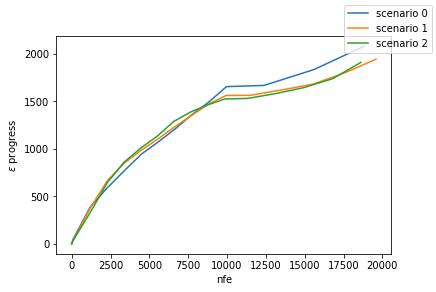

In [9]:
fig, (ax2) = plt.subplots(ncols=1)
for i, (_, convergence) in enumerate(results):
    ax2.plot(convergence["nfe"], convergence["epsilon_progress"], label=f'scenario {i}')

ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

As we can see, the algorithm shows a similar convergence behavior across all three reference case scenarios. It does however not fully converge, which - in further research - should be improved upon. 

## Selection of promising policies
We now again continue to select promising policies, first by plotting the trade-offs involved and then by subsetting the policies based on thresholds. 

In [133]:
#Make a dataframe out of all results
ms_results_df = pd.concat([results[0][0],results[1][0], results[2][0]], axis=0)
ms_results_df = ms_results_df.reset_index(drop=True)

In [135]:
#fig4 = px.parallel_coordinates(ms_results_df, labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"}, color = ms_results_df.index, dimensions= ["A1_2 Aggr Expected Annual Damage", "A3 Expected Annual Damage", "A1_2 Aggr Expected Number of Deaths","A3 Aggr Expected Number of Deaths", "A1_5 Dike Investment Costs", "Room for River Investment Costs"])
#fig4.show()

We can observe similar trade-offs as before, however, the newly found policies overall show a much better performance when it comes to casualties and damages. 

![Tradeoffs](../figures/Gelderland_Tradeoffs_3ReferenceScenario.png)


## Selection of promising policies
We select from the solutions found only these which lead to no expected deaths, no expected damage and no evacuation costs. From these selection onwards, due to comparability with the other notebooks and computational resources, we select the 10 policies with lowest total costs (Dike investment costs and Room for River costs combined)

In [8]:
ms_results_subset = ms_results_df[
    ((ms_results_df["A1_2 Aggr Expected Number of Deaths"] + ms_results_df["A3 Aggr Expected Number of Deaths"]) == 0) &
    ((ms_results_df["A1_2 Aggr Expected Annual Damage"] + ms_results_df["A3 Expected Annual Damage"]) == 0) &
    ((ms_results_df["Evacuation Costs"] + ms_results_df["Evacuation Costs"]) == 0) ]

ms_results_subset["Total Costs"] = ms_results_subset["A1_5 Dike Investment Costs"] + ms_results_subset["Room for River Investment Costs"] 


In [10]:
#Select only the 10 cheapest policies in terms of total costs. 
ms_results_subset = ms_results_subset.sort_values("Total Costs").head(10)
ms_policies = ms_results_subset.iloc[:,0:31]
ms_policies_to_evaluate = []

for i, policy in ms_policies.iterrows():
    ms_policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

## Re-evaluation under deep uncertainty
We now re-evalute the 10 policies seleted under deep uncertainty by running 1000 scenarios sampled by latin hypercube for each policy. We then determine the robustness of each policy to come to a feasible policy advice.

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, ms_policies_to_evaluate)

#Save results
save_results(results, "../results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


TypeError: can only concatenate str (not "int") to str

In [12]:
save_results(results, "../results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Gelderland.tar.gz


In [136]:
#Load results
reevaluation_results = load_results("../results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Gelderland.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Gelderland.tar.gz


In [138]:
#Show results
experiments, outcomes = reevaluation_results
reevaluation_df = pd.concat([pd.DataFrame(experiments), pd.DataFrame(outcomes)], axis = 1)
#fig5 = px.parallel_coordinates(reevaluation_df.groupby("policy").mean().iloc[:,11:42], color = range(10), width=2500, height=400)
#fig5.show()

We can see in the parallell coordinated plot, that the 10 policies selected show quite some variation. This means that the province of Gelderland has multiple options to effectively protect their citizens. 

![](../figures/Gelderland_all_Policies.png )

As this display of policies is rather messy, we display the 10 promising polices aggregated on timesteps.

In [84]:
robust_policies_agg = pd.DataFrame(columns=["RfR 0", "RfR 1", "RfR 2", "RfR 3", "RfR 4", "EWS", "A1 Increase", "A2 Increase", "A3 Increase", "A4 Increase", "A5 Increase"])
robust_policies_agg["RfR 0"] = robust_policies["0_RfR 0"] + robust_policies["0_RfR 1"] + robust_policies["0_RfR 2"]
robust_policies_agg["RfR 1"] = robust_policies["1_RfR 0"] + robust_policies["1_RfR 1"] + robust_policies["1_RfR 2"]
robust_policies_agg["RfR 2"] = robust_policies["2_RfR 0"] + robust_policies["2_RfR 1"] + robust_policies["2_RfR 2"]
robust_policies_agg["RfR 3"] = robust_policies["3_RfR 0"] + robust_policies["3_RfR 1"] + robust_policies["3_RfR 2"]
robust_policies_agg["RfR 4"] = robust_policies["4_RfR 0"] + robust_policies["4_RfR 1"] + robust_policies["4_RfR 2"]
robust_policies_agg["EWS"] = robust_policies["EWS_DaysToThreat"]
robust_policies_agg["A1 Increase"] = robust_policies["A.1_DikeIncrease 0"] + robust_policies["A.1_DikeIncrease 1"] + robust_policies["A.1_DikeIncrease 2"]
robust_policies_agg["A2 Increase"] = robust_policies["A.2_DikeIncrease 0"] + robust_policies["A.2_DikeIncrease 1"] + robust_policies["A.2_DikeIncrease 2"]
robust_policies_agg["A3 Increase"] = robust_policies["A.3_DikeIncrease 0"] + robust_policies["A.3_DikeIncrease 1"] + robust_policies["A.3_DikeIncrease 2"]
robust_policies_agg["A4 Increase"] = robust_policies["A.4_DikeIncrease 0"] + robust_policies["A.4_DikeIncrease 1"] + robust_policies["A.4_DikeIncrease 2"]
robust_policies_agg["A5 Increase"] = robust_policies["A.5_DikeIncrease 0"] + robust_policies["A.5_DikeIncrease 1"] + robust_policies["A.5_DikeIncrease 2"]


In [140]:
#fig6 = px.parallel_coordinates(robust_policies_agg, color = range(10), width=1500, height=400, dimensions=["RfR 0", "RfR 1", "RfR 2", "RfR 3", "RfR 4", "A1 Increase", "A2 Increase", "A3 Increase", "A4 Increase", "A5 Increase"])
#fig6.show()

![](../figures/Gelderland_PromisingPolicies.png )

## Robustness Assessment
### Domain criterion
For the last robustness assessment, we chose the domain criterion to assess the percentage of scenarios which fail to meet a certain outcome.  

In [142]:
domain_criterion = pd.DataFrame(columns=["policy", "A1_2 Damage", "A3 Damage", "A1_2 Deaths", "A3 Deaths", "Evacuation Costs"])

for policy in reevaluation_df["policy"].unique():
    policy_subset = reevaluation_df[reevaluation_df["policy"] == policy]

    a12_damage_dc = len(policy_subset["A1_2 Aggr Expected Annual Damage"][policy_subset["A1_2 Aggr Expected Annual Damage"] > 0])/1000
    a3_damage_dc = len(policy_subset["A3 Expected Annual Damage"][policy_subset["A3 Expected Annual Damage"] > 0])/1000
    a12_deaths_dc = len(policy_subset["A1_2 Aggr Expected Number of Deaths"][policy_subset["A1_2 Aggr Expected Number of Deaths"] > 0])/1000
    a3_deaths_dc = len(policy_subset["A3 Aggr Expected Number of Deaths"][policy_subset["A3 Aggr Expected Number of Deaths"] > 0])/1000
    evac_costs = len(policy_subset["Evacuation Costs"][policy_subset["Evacuation Costs"] > 0])/1000

    domain_criterion = domain_criterion.append(pd.DataFrame({"policy": [policy],"A1_2 Damage": [a12_damage_dc], "A3 Damage" : [a3_damage_dc], "A1_2 Deaths" : [a12_deaths_dc], "A3 Deaths" : [a3_deaths_dc], "Evacuation Costs" : [evac_costs]}) )

domain_criterion = domain_criterion.reset_index(drop=True)

In [143]:
policy_costs = reevaluation_df.groupby("policy").mean()
policy_costs["Total Costs"] = policy_costs["A1_5 Dike Investment Costs"] +  policy_costs["Room for River Investment Costs"]
domain_criterion_costs = pd.merge(domain_criterion, policy_costs[["Total Costs"]], how="left", on="policy")


In [144]:
domain_criterion_costs

,policy,A1_2 Damage,A3 Damage,A1_2 Deaths,A3 Deaths,Evacuation Costs,Total Costs
0,1289,0.468,0.050,0.468,0.050,0.0,1.342035e+09
1,1458,0.468,0.050,0.468,0.050,0.0,1.457728e+09
2,1752,0.309,0.012,0.309,0.012,0.0,1.488352e+09
3,1902,0.384,0.023,0.384,0.023,0.0,1.535650e+09
4,1144,0.050,0.027,0.050,0.027,0.0,1.687657e+09
5,1173,0.285,0.005,0.285,0.005,0.0,1.781657e+09
6,1875,0.349,0.036,0.349,0.036,0.0,1.796451e+09
7,980,0.069,0.065,0.069,0.065,0.0,1.908047e+09
8,1520,0.069,0.065,0.069,0.065,0.0,2.082841e+09
9,1477,0.309,0.060,0.309,0.060,0.0,2.103008e+09


As we can see, all policies have no evacuation costs in all the deep uncertainty runs. This is why we focus on the trade-offs in damages and deaths. The domain criterion being a dimensionless metric, we also add the total costs (Room for River costs plus Dike investment costs) in the parallel coordinated plot to show the "price of robustness". It is important to keep in mind that unlinke the domain criterion metrics, the total cost unit is monetary. 

In [147]:
#fig7 = px.parallel_coordinates(domain_criterion_costs, color = "policy", dimensions=["A1_2 Damage", "A3 Damage", "A1_2 Deaths", "A3 Deaths", "Total Costs"])
#fig7.show()

![](../figures/Gelderland_RobustPolicies.png)

As the results show, policies 980, 1144 and 1520 shows very promising results in terms of robustness. When it comes to cost, it can be seen that robustness comes along with a higher cost. It is also worth to point out that policy 980 outperforms policy 1520 having the same robustness results, but a lower cost.  

## Scenario Discovery: PRIM
At the last stage of Multi-Scenario MORDM, we will conduct another scenario dicovery using the PRIM algorithm to specifically show under which scenarios these policies fail. We consider a policy failed when either deaths or damage occurs. 

In [75]:
outcomes["condition"] = outcomes["A1_2 Aggr Expected Annual Damage"] + outcomes["A3 Expected Annual Damage"] + outcomes["A1_2 Aggr Expected Number of Deaths"] + outcomes["A3 Aggr Expected Number of Deaths"]
x = experiments.iloc[:,0:19]
y = outcomes["condition"] > 0
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 3074 cases of interest
[MainProcess/INFO] mean: 0.9961538461538462, mass: 0.052, coverage: 0.16851008458035133, density: 0.9961538461538462 restricted_dimensions: 4


In [76]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 30 as it shows a good tradeoff between density and coverage

In [79]:
n_box = 30
box.inspect(n_box)

coverage    0.541965
density     0.800962
id                30
mass           0.208
mean        0.800962
res_dim            2
Name: 30, dtype: object

              box 30                                        
                 min         max                   qp values
A.2_pfail   0.000017    0.218959                 [-1.0, 0.0]
A.1_Bmax   46.301928  349.876773  [0.2936205118550125, -1.0]

